**ДИСКЛЕЙМЕР:**

Основная часть проекта выполнена без BERT. Но мне было важно с ним разобраться, поэтому после основного проекта я сделала мини версию с BERT (без подбора гиперпараметров и только логисическая регрессия, так как если больше моделй - у меня падает kernell) на обрезанном датасете (до 1000 записей)

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Выбор-лучшей-модели-+-тестирование" data-toc-modified-id="Выбор-лучшей-модели-+-тестирование-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Выбор лучшей модели + тестирование</a></span></li><li><span><a href="#Проверка-на-тестовой-выборке" data-toc-modified-id="Проверка-на-тестовой-выборке-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Проверка на тестовой выборке</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [ ]:
!pip install -q imblearn

In [1]:
import numpy as np
import warnings 

from scipy import stats as st
import seaborn as sns
warnings.filterwarnings('ignore') # отключаем предупреждения

import pandas as pd
import matplotlib.pyplot as plt



from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier,DummyRegressor
from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb

import torch
import transformers 


from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, mean_squared_error, confusion_matrix, f1_score, roc_curve, roc_auc_score,r2_score,mean_absolute_error

from sklearn.preprocessing import OrdinalEncoder,StandardScaler,OneHotEncoder
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer

from tqdm import tqdm, notebook



2023-03-12 17:11:18.958637: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from pymystem3 import Mystem
import re 

In [37]:
import nltk
from nltk.corpus import stopwords as nltk_stopwords

from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold

## Подготовка

In [4]:
try:
    data = pd.read_csv('toxic_comments.csv')
except:
    data = pd.read_csv('/datasets/toxic_comments.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [6]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
data.isna().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

In [8]:
data.duplicated().sum()

0

In [9]:
data['text'].duplicated().sum()

0

Дубликтатов как во всем датасете так и в столбце с текстами нет. Так же пропуски в данных отсуствуют.

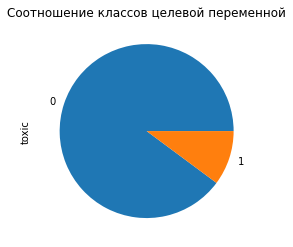

In [10]:
data['toxic'].value_counts().plot(kind='pie',title='Соотношение классов целевой переменной');

Так же мы ожем наблюдать заметный дисбаланс классов. Далее будем с ним работать.

In [11]:
#зададим функции для очищения текста от ненужных символов и лемматизации
def lemmatize(text):
    #так как тексты с которыми работаем англоязычные подбираем функцию лемматизации поддерживающую английкий язык
    wnl = WordNetLemmatizer()
    
    lemm_list =[wnl.lemmatize(x,pos='v') for x in text.split()]
    lemm_text = " ".join(lemm_list)
        
    return lemm_text


def clear_text(text):
    t=re.sub(r"[^a-zA-z']", ' ', text)
    t=" ".join(t.split())
    return t.lower()

In [12]:
data['clear_text']= data['text'].apply(lambda x: clear_text(x))

In [13]:
data['lemm_text']=data['clear_text'].apply(lambda x: lemmatize(x))

In [14]:
data.head()

,Unnamed: 0,text,toxic,clear_text,lemm_text
0,0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation why the edit make under my usernam...
1,1,D'aww! He matches this background colour I'm s...,0,d'aww he matches this background colour i'm se...,d'aww he match this background colour i'm seem...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man i'm really not trying to edit war it's...,hey man i'm really not try to edit war it's ju...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,more i can't make any real suggestions on impr...,more i can't make any real suggestions on impr...
4,4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...,you sir be my hero any chance you remember wha...


Для верного формирования мешков слов и в последствии получения векторов разделим датасет на обучающую и тестовую  и валидационную выборки.

In [15]:
train_valid ,test = train_test_split(data, test_size=0.2, random_state=12345,stratify=data['toxic'])
train, valid  = train_test_split(train_valid, test_size=0.25, random_state=12345,stratify=train_valid['toxic'])

In [16]:
train_target = train['toxic']
valid_target = valid['toxic']
test_target = test['toxic']
train_valid_target = train_valid['toxic']

train_features = train['lemm_text']
valid_features = valid['lemm_text']
test_features = test['lemm_text']
train_valid_features = train_valid['lemm_text']

***Борьба с дисбалансом***

In [63]:
#посчитаем коффициент дисбаланса
disbalanse_coef = int(sum(train_target==0)/ sum(train_target==1))
disbalanse_coef_frac = round(sum(train_target==1)/ sum(train_target==0),2)

In [18]:
#зададим функцию апсемплинга и даунсемплинга
def upsample(features, target, repeat): 
    features_zeros = features[target == 0] 
    features_ones = features[target == 1]
    target_zeros = target[target == 0] 
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat) 
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(\
                            features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

def downsample(features, target, fraction):
    features_zeros = features[target == 0] 
    features_ones = features[target == 1] 
    target_zeros = target[target == 0] 
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [19]:
train_features_up,train_target_up = upsample(train_features,train_target,disbalanse_coef)
#train_features_down,train_target_down = downsample(train_features,train_target,disbalanse_coef_frac)

In [20]:
corpus_train_up=train_features_up.values
#corpus_train_down=train_features_down.values
corpus_train=train_features.values

corpus_valid=valid_features.values

corpus_test=test_features.values

In [21]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/makkate/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


cоставим векторы только отдельных слов (со словосочетаниями при кол-ве features dв 3500  качество моделей падает, а увеличить число не могу так как не хватает оперативной памяти)

используем TfidfVectorizer вместо count_vectorzer, так как перед нами стоит задача определения тональности теста

In [22]:

count_tf_idf = TfidfVectorizer(stop_words=list(stopwords),ngram_range=(1,1),max_features=3500)
count_tf_idf.fit(corpus_train_up)

TfidfVectorizer(max_features=3500,
                stop_words=['be', 'from', 'any', 'll', 'through', 've',
                            'yourself', 'haven', 'been', 'between', 'below',
                            'i', 'as', 'during', 'in', 'now', 'and', 'o',
                            'which', 'if', 'she', 'themselves', "you'll", 'we',
                            'her', "shan't", "won't", 'there', 'some', 'no', ...])

Сформируем векторы для обучающей и валидационных выборок.

In [23]:
tf_idf_train_up=count_tf_idf.transform(corpus_train_up)
tf_idf_valid = count_tf_idf.transform(corpus_valid)

Сформируем векторы тестовой выбороки для проверки итоговой модели.

In [24]:
tf_idf_test = count_tf_idf.transform(corpus_test)

In [25]:
tf_idf_test.shape

(31859, 3500)

## Обучение

***Logistic Regression***

In [26]:
model = LogisticRegression(random_state=12345)

In [27]:
model.fit(tf_idf_train_up,train_target_up)
predict = model.predict(tf_idf_valid)
f1_logistic = f1_score(valid_target,predict)
print(f'''f1 для логистической регрессии составила {f1_logistic}''')

f1 для логистической регрессии составила 0.7179621162638798


In [28]:
params_log="-"

***RandomForest***

In [29]:
model = RandomForestClassifier(random_state=12345,n_jobs=-1)

In [30]:
%%time
model.fit(tf_idf_train_up,train_target_up)
predict = model.predict(tf_idf_valid)
f1_RF = f1_score(valid_target,predict)
print(f'''f1 для Случайного леса составила {f1_RF}''')

f1 для Случайного леса составила 0.7415503615268203
CPU times: user 17min 49s, sys: 9.19 s, total: 17min 58s
Wall time: 5min 22s


In [431]:
%%time
f1_max=-1000
for n_est in range(70,350,70):
    for depth in range(1,20,5):
        model = RandomForestClassifier(random_state=12345,max_depth=depth, n_estimators = n_est)
        model.fit(tf_idf_train_up,train_target_up)
        predict = model.predict(tf_idf_valid)
        f1 = f1_score(valid_target,predict)
        if f1>f1_max:
            f1_max=f1
            best_model=model
print(best_model)

RandomForestClassifier(max_depth=6, n_estimators=70, random_state=12345)
CPU times: user 4min 50s, sys: 3.15 s, total: 4min 53s
Wall time: 4min 54s


In [439]:
f1_max

0.6740753603056087

In [440]:
params_RF='-'

In [441]:
model.fit(tf_idf_train_up,train_target_up)
predict = model.predict(tf_idf_valid)
f1_RF = f1_score(valid_target,predict)


При подборе гиперпараметров для случайного леса мне не удалось улучшить f1 - модель переобучилась (о чем говорит большая глубина леса). Как итоговый варинат случайного леса предлагаю оставить настройки по-умолчанию.

***CatboostClassifier***

In [144]:
%%time
model = CatBoostClassifier()
model.fit(tf_idf_train_up,train_target_up,verbose=500)
predict = model.predict(tf_idf_valid)
f1_CB = f1_score(valid_target,predict)
print(f'''f1 для Случайного леса составила {f1_CB}''')

Learning rate set to 0.090818
0:	learn: 0.6476694	total: 1.27s	remaining: 21m 12s
500:	learn: 0.2233034	total: 5m 27s	remaining: 5m 25s
999:	learn: 0.1660713	total: 10m 55s	remaining: 0us
f1 для Случайного леса составила 0.7568498063405537
CPU times: user 35min 8s, sys: 16.9 s, total: 35min 25s
Wall time: 10min 58s


In [452]:
params_CB="-"


Поскольку обучение данной модели занимает много времени, а получившийся результат метрики удовлетворяет условию - я не стану подбирать гиперпараметры.

***LightGBM***

In [146]:
%%time
model = lgb.LGBMClassifier(n_jobs=-1)
model.fit(tf_idf_train_up,train_target_up,verbose=300)
predict = model.predict(tf_idf_valid)
f1_LGB = f1_score(valid_target,predict)
print(f'''f1 для LightGBM составила {f1_LGB}''')

f1 для LightGBM составила 0.7389317337903455
CPU times: user 1min 26s, sys: 2.16 s, total: 1min 28s
Wall time: 37.3 s


In [444]:
%%time
f1_max=-1000
for depth in range(-1,16,3):
    for n_est in range(70,400,50):
        for l_rate in[0.1,0.3,0.8]:
            model = lgb.LGBMClassifier(n_jobs=-1,
                                       max_depth = depth, 
                                       n_estimators = n_est,
                                       learning_rate = l_rate)
            model.fit(tf_idf_train_up,train_target_up,verbose=300)
            predict = model.predict(tf_idf_valid)
            f1 = f1_score(valid_target,predict)
            if f1>f1_max:
                best_model=model
                f1_max=f1

CPU times: user 3h 19min 13s, sys: 3min 37s, total: 3h 22min 51s
Wall time: 59min 5s


In [445]:
print(best_model.get_params)
print(f1_max)

<bound method LGBMModel.get_params of LGBMClassifier(learning_rate=0.3, max_depth=14, n_estimators=370)>
0.771062271062271


In [446]:
f1_LGB = f1_max
params_LGB = best_model.get_params


***XGBoost***

In [149]:
%%time
model = xgb.XGBClassifier(n_jobs=-1)
model.fit(tf_idf_train_up,train_target_up,verbose=300)
predict = model.predict(tf_idf_valid)
f1_XGB = f1_score(valid_target,predict)
print(f'''f1 для XGBoost составила {f1_XGB}''')

f1 для XGBoost составила 0.7431220095693779
CPU times: user 3min 17s, sys: 942 ms, total: 3min 18s
Wall time: 54.3 s


In [450]:
%%time
f1_max=-1000
for depth in range(1,16,5):
    for n_est in range(70,400,50):
        
        model = xgb.XGBClassifier(n_jobs=-1,
                                       max_depth = depth, 
                                       n_estimators = n_est)
        model.fit(tf_idf_train_up,train_target_up,verbose=300)
        predict = model.predict(tf_idf_valid)            
        f1 = f1_score(valid_target,predict)
        if f1>f1_max: 
            best_model=model
            f1_max=f1

CPU times: user 2h 34min 15s, sys: 1min 1s, total: 2h 35min 17s
Wall time: 42min 35s


In [451]:
print(best_model.get_params)
print(f1_max)

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=270, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)>
0.7667741440196529


In [454]:
f1_XGB=f1_max
params_XGB = best_model.get_params

### Выбор лучшей модели + тестирование

In [455]:
models=['Logistic Regression','Random Forest Classifier','CatBoost Classifier','LightGBM Classifier','XGBoost Classifier']
models_f1=[f1_logistic,f1_RF,f1_CB,f1_LGB,f1_XGB]
models_params=[params_log,params_RF,params_CB,params_LGB,params_XGB]

models_comparison=pd.DataFrame(list(zip(models_f1,models_params)),columns=['F1-score','Model_params'],index=models)

models_comparison = models_comparison.sort_values(by='F1-score',ascending = False)

models_comparison

,F1-score,Model_params
LightGBM Classifier,0.771062,<bound method LGBMModel.get_params of LGBMClas...
XGBoost Classifier,0.766774,<bound method XGBModel.get_params of XGBClassi...
CatBoost Classifier,0.756850,-
Logistic Regression,0.717962,-
Random Forest Classifier,0.674075,-


In [456]:
models_comparison.iloc[0]

F1-score                                                 0.771062
Model_params    <bound method LGBMModel.get_params of LGBMClas...
Name: LightGBM Classifier, dtype: object

### Проверка на тестовой выборке

In [457]:
model = lgb.LGBMClassifier(n_jobs=-1, max_depth = 14, n_estimators =370,learning_rate = 0.3)
model.fit(tf_idf_train_up,train_target_up,verbose=300)
predict = model.predict(tf_idf_test)



In [458]:
print(f'''f1 для LightGBM на тестовой составила {f1_score(test_target,predict)}''')

f1 для LightGBM на тестовой составила 0.7700567571713453


На тесте модель показала стабильный результат, что говорит об устойчивости качества предскзаания выбранной модели.

## Выводы

В рамках данного проекта передо мной стояла задача обучения модели машинного обучения, которая могла бы помочь сервису более эффективно модерировать пользовательские описания контекта и своевременно сигнализировать о появлении токсичных пользовательских текстах в катрочках товаров.

Для выполнения данной задачи мною была произведена предобработка уже размеченной базы данных: очистка текстов от служебных символов и лемматизация (приведение к начальной форме слов). Далее Передо мной стояла задача перевода имеющися текстов векторы. Для этого я выбрала способ, учитывающий не только частотность слова, но и его важность, определяемая величиной TF-IDF. 

Поскольку я работаю в рамках ограниченной памяти, то мне пришлось ограничить кол-во параметров для построения векторов до 3500. Однако перед тем как векторизовать данные с целью сгладить дисбаланс классов я произвела апсмплинг обучающей выборки и это помогла в дальнейшем избежать дисбаланса параметров при векторизации (векторизатор обучался так же на выборке, где токстичные и нетоксичные тексты были в равных долях, а занчит частотности токсичных/нестоксичных параметров были +- уравнены). Для обучения моделей это так же помогло повысить уровень предсказательной способности. 

Далее я протестировала 5 моделей на валидационной выборке (выборочно производя подбор гипермараметров модели, где это казалось оправданным). В итоге модель, показавшая лушчий f1 оказался бустинг LightGBM, с f1 равным 0.771 и 0.770 на валидационной и тестовой соотвественно.

# Bert

In [1]:
import numpy as np
import pandas as pd
import torch
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import f1_score


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier,DummyRegressor
from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb


2023-03-10 11:44:00.807290: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
try:
    data = pd.read_csv('toxic_comments.csv')
except:
    data = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
data = data.sample(1000).reset_index(drop=True) 

In [4]:
model_class = ppb.DistilBertModel
tokenizer_class = ppb.DistilBertTokenizer
pretrained_weights = 'distilbert-base-uncased'

In [5]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)

In [6]:
tokenized = data['text'].apply(\
            lambda x: tokenizer.encode(x, add_special_tokens=True)) 

Token indices sequence length is longer than the specified maximum sequence length for this model (1069 > 512). Running this sequence through the model will result in indexing errors


In [7]:
tokenized=pd.DataFrame(tokenized)
#обрежем длинные строки
tokenized['text'] = tokenized['text'].apply(lambda x: x[:512])
tokenized=tokenized.loc[:,'text']

In [8]:
n=max([len(i) for i in tokenized])

In [9]:
padded = np.array([i + [0]*(n - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
from tqdm import notebook 
# преобразуем данные

batch_size = 100
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    embeddings.append(batch_embeddings[0][:,0,:].numpy()) 
    
features = np.concatenate(embeddings) 

  0%|          | 0/10 [00:00<?, ?it/s]

In [11]:
targets=data['toxic']

In [12]:
#разделим выборки на обучающую, валидационную и тестовую
train_features, test_features, train_target, test_target = \
        train_test_split(features, targets, test_size=0.2,stratify=targets)

train_features, valid_features, train_target, valid_target =\
    train_test_split(train_features, train_target, test_size=0.25,stratify=train_target)

In [13]:
train_features=pd.DataFrame(train_features,index=train_target.index)
valid_features=pd.DataFrame(valid_features,index=valid_target.index)
test_features=pd.DataFrame(test_features,index=test_target.index)

In [14]:
def upsample(features, target, repeat): 
    features_zeros = features[target == 0] 
    features_ones = features[target == 1]
    target_zeros = target[target == 0] 
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat) 
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(\
                            features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

In [15]:
disbalanse_coef = int(sum(train_target==0)/ sum(train_target==1))

In [16]:
#для борьбы с дисбалансом произведу апсемплинг обучащей выборки
train_features_up,train_target_up = upsample(pd.DataFrame(train_features), train_target, disbalanse_coef)

## Обучение

***Logistic Regression***

In [17]:
model = LogisticRegression(random_state=12345)

In [18]:
model.fit(train_features_up,train_target_up)
predict = model.predict(valid_features)
f1_logistic = f1_score(valid_target,predict)
print(f'''f1 для логистической регрессии составила {f1_logistic}''')

f1 для логистической регрессии составила 0.7391304347826088


/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Проверка на тестовой

In [19]:
model = LogisticRegression(random_state=12345)

model.fit(train_features_up,train_target_up)
predict = model.predict(test_features)
f1_logistic = f1_score(test_target,predict)
print(f'''f1 для логистической регрессии на тестовой выборке составила {f1_logistic}''')

/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


f1 для логистической регрессии на тестовой выборке составила 0.6341463414634146
